In [1]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
data = np.load('../record/results_2025-07-30-18-34/data/spike_countsWT1p6000_NC3N0100.npz')

In [3]:
rng = np.random.default_rng(100)

def separate_data(rng, num_segments=10):
    data_to_segment = rng.integers(0, num_segments, size=np.size(data['time']))
    return data_to_segment

In [4]:
data_to_segment = separate_data(rng)

In [5]:
lda = LinearDiscriminantAnalysis(n_components=1)

In [6]:
data['input_seq']

array([ 1,  1, 15, ...,  1,  1, 15], shape=(10000,))

In [7]:
z = lda.fit(data['soma_potentials'],  data['input_seq']).transform(data['soma_potentials'])

In [8]:
data['input_seq']

array([ 1,  1, 15, ...,  1,  1, 15], shape=(10000,))

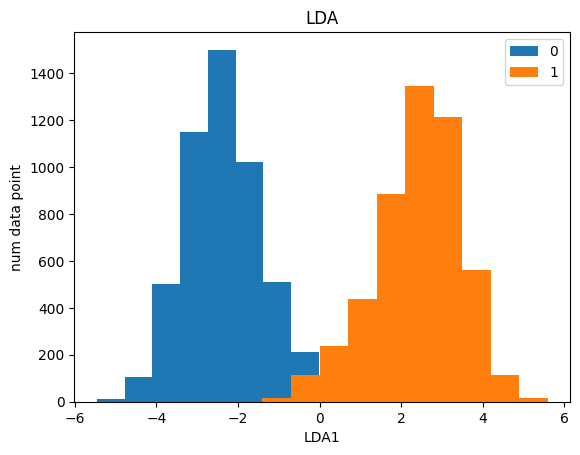

In [9]:
from matplotlib import pyplot as plt
colors = ['blue', 'red']
for color, i, target_name in zip(colors, [1, 15], [0, 1]):
    plt.hist(z[data['input_seq'] == i, 0],
                label=target_name)
plt.xlabel('LDA1')
plt.ylabel('num data point')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA')
plt.show()

In [10]:
# remove transient period
data_without_transient = {}
data_without_transient['time'] = data['time'][100:]
data_without_transient['soma_potentials'] = data['soma_potentials'][100:]
data_without_transient['input_seq'] = data['input_seq'][100:]

In [11]:
def split_data_into_groups(input_pattern, ca1_output, d, m):
    d_input_history = np.zeros((np.size(input_pattern), d))
    for i in range(d-1, np.size(input_pattern)):
        d_input_history[i, :] = input_pattern[i-d+1:i+1]

    num_groups = m**(d-1)
    group = np.zeros(np.size(input_pattern))
    for i in range(d-1):
        group[i] = None

    for i in range(d-1, np.size(input_pattern)):
        for j in range(d-1):
            group[i] += d_input_history[i, j] * m**j

    return group

In [12]:
def rename_input_pattern(input_seq):
    new_input_pattern = np.zeros(np.size(input_seq))
    No_input_pattern = np.unique(input_seq)
    for idx, input in enumerate(input_seq):
        for new_input, old_input in enumerate(No_input_pattern):
            if input == old_input:
                new_input_pattern[idx] = new_input

    return new_input_pattern

In [13]:
data_without_transient['input_seq'] = rename_input_pattern(data_without_transient['input_seq'])

In [14]:
data_without_transient['group'] = split_data_into_groups(data_without_transient['input_seq'], data_without_transient['soma_potentials'], 1, 2)

In [15]:
data_without_transient['input_seq']

array([0., 1., 1., ..., 0., 0., 1.], shape=(9900,))

In [16]:
if np.all(data_without_transient['input_seq'] == data_without_transient['group']):
    print('true')

In [17]:
def _get_data_within_group(group, data_to_group, input_seq, ca1_output):
    new_data = {}
    new_data['input_seq'] = input_seq[np.where(data_to_group == group)]
    new_data['soma_potentials'] = ca1_output[np.where(data_to_group == group)]
    new_data['group'] = data_to_group[np.where(data_to_group == group)]
    new_data['num_data'] = np.size(new_data['input_seq'])

    return new_data

In [18]:
data_in_group_1 = _get_data_within_group(1,  data_without_transient['group'], data_without_transient['input_seq'], data_without_transient['soma_potentials'])

In [19]:
data_in_group_0 = _get_data_within_group(0,  data_without_transient['group'], data_without_transient['input_seq'], data_without_transient['soma_potentials'])

In [20]:
def split_data_into_segments(num_data, num_segments):
    data_to_segment = rng.integers(0, num_segments, size=num_data)
    return data_to_segment

In [21]:
def _get_data_within_segments(segment, data_to_segment, input_seq, ca1_output):
    new_data = {}
    new_data['input_seq'] = input_seq[np.where(data_to_segment == segment)]
    new_data['soma_potentials'] = ca1_output[np.where(data_to_segment == segment)]
    new_data['segment'] = data_to_segment[np.where(data_to_segment == segment)]
    new_data['num_data'] = np.size(new_data['input_seq'])

    return new_data

In [22]:
def calculate_centroid(z, input_seq, m):
    centroid = []
    for i in range(m):
        centroid.append(np.mean(z[input_seq==i]))
    return centroid

def classify_validate_data(centroid, z_validate):
    estimation = np.zeros(np.size(z_validate))
    for z_idx, z in enumerate(z_validate):
        minimum_distance = np.max(z_validate) - np.min(z_validate)
        for cls, centroid_of_class in enumerate(centroid):
            if abs(centroid_of_class - z) < minimum_distance:
                minimum_distance = abs(centroid_of_class - z)
                estimation[z_idx] = cls
    return estimation
            
def calculate_ER(estimation, ground_truth):
    num_error = 0
    for est, truth in zip(estimation, ground_truth):
        if est != truth:
            num_error += 1
    
    return num_error / np.size(estimation)


def conduct_lda(input_seq, ca1_output, data_to_segment, segment, m, d):
    print(f'conduct lda for segment {segment}')
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    lda = LinearDiscriminantAnalysis(n_components=m-1)
    z = lda.fit(ca1_output[data_to_segment!=segment], input_seq[data_to_segment!=segment]).transform(ca1_output[data_to_segment!=segment])
    z_validate = lda.transform(ca1_output[data_to_segment==segment])
    estimated_class = classify_validate_data(calculate_centroid(z, input_seq[data_to_segment!=segment], m), z_validate)
    ER = calculate_ER(estimated_class, input_seq[data_to_segment==segment])
    return ER

In [23]:
num_segments = 10
d = 1
m = 2
num_groups = m**(d-1)
num_all_data = 0
data_without_transient['group'] = split_data_into_groups(data_without_transient['input_seq'], data_without_transient['soma_potentials'], d, m)
for i in range(num_groups):
    data_in_group = _get_data_within_group(i,  data_without_transient['group'], data_without_transient['input_seq'], data_without_transient['soma_potentials'])
    print(f'LDA for group {i}')
    print(f'num data in group {i} = {data_in_group['num_data']}')
    error_rate = np.zeros(num_segments)

    # conduct validation for segment 0
    segment = 0
    data_to_segments = split_data_into_segments(data_in_group['num_data'], num_segments)
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    z = lda.fit(data_in_group['soma_potentials'][data_to_segments!=segment], data_in_group['input_seq'][data_to_segments!=segment]).transform(data_in_group['soma_potentials'][data_to_segments!=segment])
    z_validate = lda.transform(data_in_group['soma_potentials'][data_to_segments==segment])
    estimated_class = classify_validate_data(calculate_centroid(z, data_in_group['input_seq'][data_to_segments!=segment], m), z_validate)
    ER = calculate_ER(estimated_class, data_in_group['input_seq'][data_to_segments==segment])
    print(ER)
    num_all_data += data_in_group['num_data']
print(f'number of all data is {num_all_data}')

LDA for group 0
num data in group 0 = 9900
0.017364657814096015
number of all data is 9900


In [24]:
num_segments = 10
d = 1
m = 2
num_groups = m**(d-1)
num_all_data = 0
data_without_transient['group'] = split_data_into_groups(data_without_transient['input_seq'], data_without_transient['soma_potentials'], d, m)
print(data_without_transient['group'])
for i in range(num_groups):
    data_in_group = _get_data_within_group(i,  data_without_transient['group'], data_without_transient['input_seq'], data_without_transient['soma_potentials'])
    print(f'LDA for group {i}')
    print(f'num data in group {i} = {data_in_group['num_data']}')
    error_rate = np.zeros(num_segments)
    for j in range(num_segments):
        data_to_segments = split_data_into_segments(data_in_group['num_data'], num_segments)
        error_rate[j] = conduct_lda(data_in_group['input_seq'], data_in_group['soma_potentials'], data_to_segments, j, m, d)
        print(error_rate[j])
    print(np.mean(error_rate))
    num_all_data += data_in_group['num_data']
print(f'number of all data is {num_all_data}')

[0. 0. 0. ... 0. 0. 0.]
LDA for group 0
num data in group 0 = 9900
conduct lda for segment 0
0.019076305220883535
conduct lda for segment 1
0.014767932489451477
conduct lda for segment 2
0.025150905432595575
conduct lda for segment 3
0.022821576763485476
conduct lda for segment 4
0.021384928716904276
conduct lda for segment 5
0.022703818369453045
conduct lda for segment 6
0.01694915254237288
conduct lda for segment 7
0.017928286852589643
conduct lda for segment 8
0.023350253807106598
conduct lda for segment 9
0.013388259526261586
0.019752141972110407
number of all data is 9900


In [25]:
num_segments = 10
d = 2
m = 2
num_groups = m**(d-1)
num_all_data = 0
data_without_transient['group'] = split_data_into_groups(data_without_transient['input_seq'], data_without_transient['soma_potentials'], d, m)
print(data_without_transient['group'])
for i in range(num_groups):
    data_in_group = _get_data_within_group(i,  data_without_transient['group'], data_without_transient['input_seq'], data_without_transient['soma_potentials'])
    print(f'LDA for group {i}')
    print(f'num data in group {i} = {data_in_group['num_data']}')
    error_rate = np.zeros(num_segments)
    for j in range(num_segments):
        data_to_segments = split_data_into_segments(data_in_group['num_data'], num_segments)
        error_rate[j] = conduct_lda(data_in_group['input_seq'], data_in_group['soma_potentials'], data_to_segments, j, m, d)
        print(error_rate[j])
    print(np.mean(error_rate))
    num_all_data += data_in_group['num_data']
print(f'number of all data is {num_all_data}')

[nan  0.  1. ...  1.  0.  0.]
LDA for group 0
num data in group 0 = 5014
conduct lda for segment 0
0.0
conduct lda for segment 1
0.0
conduct lda for segment 2
0.0
conduct lda for segment 3
0.0
conduct lda for segment 4
0.0
conduct lda for segment 5
0.0
conduct lda for segment 6
0.0
conduct lda for segment 7
0.0
conduct lda for segment 8
0.0
conduct lda for segment 9
0.0
0.0
LDA for group 1
num data in group 1 = 4885
conduct lda for segment 0
0.0
conduct lda for segment 1
0.0
conduct lda for segment 2
0.0
conduct lda for segment 3
0.0
conduct lda for segment 4
0.0
conduct lda for segment 5
0.0
conduct lda for segment 6
0.0
conduct lda for segment 7
0.0
conduct lda for segment 8
0.0
conduct lda for segment 9
0.0
0.0
number of all data is 9899


In [26]:
num_segments = 10
d = 1
m = 2
num_groups = m**(d-1)
num_all_data = 0
data_without_transient['group'] = split_data_into_groups(data_without_transient['input_seq'], data_without_transient['soma_potentials'], d, m)
print(data_without_transient['group'])
for i in range(num_groups):
    data_in_group = _get_data_within_group(i,  data_without_transient['group'], data_without_transient['input_seq'], data_without_transient['soma_potentials'])
    print(f'LDA for group {i}')
    print(f'num data in group {i} = {data_in_group['num_data']}')
    error_rate = np.zeros(num_segments)
    for j in range(num_segments):
        data_to_segments = split_data_into_segments(data_in_group['num_data'], num_segments)
        error_rate[j] = conduct_lda(data_in_group['input_seq'], data_in_group['soma_potentials'], data_to_segments, j, m, d)
        print(error_rate[j])
    print(np.mean(error_rate))
    num_all_data += data_in_group['num_data']
print(f'number of all data is {num_all_data}')

[nan nan  2. ...  3.  1.  0.]
LDA for group 0
num data in group 0 = 2555
conduct lda for segment 0
0.0
conduct lda for segment 1
0.0
conduct lda for segment 2
0.0
conduct lda for segment 3
0.0
conduct lda for segment 4
0.0
conduct lda for segment 5
0.0
conduct lda for segment 6
0.0
conduct lda for segment 7
0.0
conduct lda for segment 8
0.0
conduct lda for segment 9
0.0
0.0
LDA for group 1
num data in group 1 = 2458
conduct lda for segment 0
0.0
conduct lda for segment 1
0.0
conduct lda for segment 2
0.0
conduct lda for segment 3
0.0
conduct lda for segment 4
0.0
conduct lda for segment 5
0.0
conduct lda for segment 6
0.0
conduct lda for segment 7
0.0
conduct lda for segment 8
0.0
conduct lda for segment 9
0.0
0.0
LDA for group 2
num data in group 2 = 2458
conduct lda for segment 0
0.0
conduct lda for segment 1
0.0
conduct lda for segment 2
0.0
conduct lda for segment 3
0.0
conduct lda for segment 4
0.0
conduct lda for segment 5
0.0
conduct lda for segment 6
0.0
conduct lda for segment

In [27]:
num_segments = 10
d = 4
m = 2
num_groups = m**(d-1)
num_all_data = 0
data_without_transient['group'] = split_data_into_groups(data_without_transient['input_seq'], data_without_transient['soma_potentials'], d, m)
for i in range(num_groups):
    data_in_group = _get_data_within_group(i,  data_without_transient['group'], data_without_transient['input_seq'], data_without_transient['soma_potentials'])
    print(f'LDA for group {i}')
    print(f'num data in group {i} = {data_in_group['num_data']}')
    num_all_data += data_in_group['num_data']
print(f'number of all data is {num_all_data}')

LDA for group 0
num data in group 0 = 1276
LDA for group 1
num data in group 1 = 1279
LDA for group 2
num data in group 2 = 1245
LDA for group 3
num data in group 3 = 1213
LDA for group 4
num data in group 4 = 1278
LDA for group 5
num data in group 5 = 1179
LDA for group 6
num data in group 6 = 1213
LDA for group 7
num data in group 7 = 1214
number of all data is 9897


In [28]:
num_segments = 10
d = 5
m = 2
num_groups = m**(d-1)
num_all_data = 0
data_without_transient['group'] = split_data_into_groups(data_without_transient['input_seq'], data_without_transient['soma_potentials'], d, m)
for i in range(num_groups):
    data_in_group = _get_data_within_group(i,  data_without_transient['group'], data_without_transient['input_seq'], data_without_transient['soma_potentials'])
    print(f'LDA for group {i}')
    print(f'num data in group {i} = {data_in_group['num_data']}')
    num_all_data += data_in_group['num_data']

LDA for group 0
num data in group 0 = 632
LDA for group 1
num data in group 1 = 644
LDA for group 2
num data in group 2 = 654
LDA for group 3
num data in group 3 = 625
LDA for group 4
num data in group 4 = 658
LDA for group 5
num data in group 5 = 587
LDA for group 6
num data in group 6 = 583
LDA for group 7
num data in group 7 = 630
LDA for group 8
num data in group 8 = 644
LDA for group 9
num data in group 9 = 634
LDA for group 10
num data in group 10 = 591
LDA for group 11
num data in group 11 = 588
LDA for group 12
num data in group 12 = 620
LDA for group 13
num data in group 13 = 592
LDA for group 14
num data in group 14 = 630
LDA for group 15
num data in group 15 = 584
